# Analyze Data

Korte data analyse voor het verkenne van de yelp data voor het verslag van week 1.

In [1]:
# Imports
import pandas as pd
import os
import json
import random
from IPython.display import display
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
from sklearn.model_selection import train_test_split
import numpy as np
import operator

In [2]:
"""
This file loads the data from the data directory and shows you how.
Feel free to change the contents of this file!
Do ensure these functions remain functional:
    - get_business(city, business_id)
    - get_reviews(city, business_id=None, user_id=None, n=10)
    - get_user(username)
"""

import os
import json
import random

DATA_DIR = "../data"


def load_cities():
    """
    Finds all cities (all directory names) in ./data
    Returns a list of city names
    """
    return os.listdir(DATA_DIR)


def load(cities, data_filename):
    """
    Given a list of city names,
        for each city extract all data from ./data/<city>/<data_filename>.json
    Returns a dictionary of the form:
        {
            <city1>: [<entry1>, <entry2>, ...],
            <city2>: [<entry1>, <entry2>, ...],
            ...
        }
    """
    data = {}
    for city in cities:
        city_data = []
        with open(f"{DATA_DIR}/{city}/{data_filename}.json", "r") as f:
            for line in f:
                city_data.append(json.loads(line))
        data[city] = city_data
    return data


def get_business(city, business_id):
    """
    Given a city name and a business id, return that business's data.
    Returns a dictionary of the form:
        {
            name:str,
            business_id:str,
            stars:str,
            ...
        }
    """
    for business in BUSINESSES[city]:
        if business["business_id"] == business_id:
            return business
    raise IndexError(f"invalid business_id {business_id}")


def get_reviews(city, business_id=None, user_id=None, n=10):
    """
    Given a city name and optionally a business id and/or auser id,
    return n reviews for that business/user combo in that city.
    Returns a dictionary of the form:
        {
            text:str,
            stars:str,
            ...
        }
    """
    def should_keep(review):
        if business_id and review["business_id"] != business_id:
            return False
        if user_id and review["user_id"] != user_id:
            return False
        return True

    reviews = REVIEWS[city]
    reviews = [review for review in reviews if should_keep(review)]
    return random.sample(reviews, min(n, len(reviews)))


def get_user(username):
    """
    Get a user by its username
    Returns a dictionary of the form:
        {
            user_id:str,
            name:str,
            ...
        }
    """
    for city, users in USERS.items():
        for user in users:
            if user["name"] == username:
                return user
    raise IndexError(f"invalid username {username}")


#CITIES = load_cities()
#USERS = load(CITIES, "user")
#BUSINESSES = load(CITIES, "business")
#REVIEWS = load(CITIES, "review")
#TIPS = load(CITIES, "tip")
#CHECKINS = load(CITIES, "checkin")


In [3]:
''' Schoonmaken BUSINESSES'''
#business = citymerge(BUSINESSES)
#business = business[business['is_open'] == 1 & business['categories'].notna()]
#business['categories'] = business['categories'].str.split(', ')
#print(business.latitude.mean(), business.longitude.mean())

' Schoonmaken BUSINESSES'

In [4]:
# Functie om data van alle steden samen te voegen in 1 DataFrame
def citymerge(var):
    return pd.concat([pd.DataFrame(var[city]) for city in var]).reset_index()

In [5]:
CITY = 'westlake'
reviews = pd.read_json(DATA_DIR+'/'+CITY+'/review.json', lines=True)
businesses = pd.read_json(DATA_DIR+'/'+CITY+'/business.json', lines=True)
#businesses = citymerge(BUSINESSES)
reviews_train, review_test = train_test_split(reviews, random_state=4)#citymerge(REVIEWS)

In [6]:
# Creeer Utility Matrix en Mean Utility Matrix uit een variabele van data.py (REVIEWS, USERS, BUSINESSES, etc.)
def create_utility_matrix(df):

    utility_matrix  = pd.pivot_table(df, index='business_id', columns='user_id', values='stars')

    mean_ultility_matrix = utility_matrix - utility_matrix.mean()
    
    return utility_matrix, mean_ultility_matrix
    
utility_matrix, mean_utility_matrix = create_utility_matrix(reviews_train)

In [7]:
def manhattan_similarity(matrix, id1, id2):
    """Compute manhattan similarity between two rows."""
    # compute distance
    distance = manhattan_distances(matrix, id1, id2)
    
    # if no distance could be computed (no shared features) return a similarity of 0
    if distance is np.nan:
        return 0
    
    # else return similarity
    return 1 / (1 + distance)

In [8]:
# Creeer Similarity Matrix uit Mean Utility Matrix
def similarity(mum):
    similarity_matrix_cosine = pd.DataFrame(cosine_similarity(mum.fillna(0)), index=mum.index, columns=mum.index).replace(0, np.nan)
    similarity_matrix_manhattan = 1 / (pd.DataFrame(manhattan_distances(mum.fillna(0)), index=mum.index, columns=mum.index).replace(0, np.nan) +1)
    similarity_matrix_euclidean = 1 / (pd.DataFrame(euclidean_distances(mum.fillna(0)), index=mum.index, columns=mum.index).replace(0, np.nan) +1)
    
    return similarity_matrix_cosine, similarity_matrix_manhattan, similarity_matrix_euclidean   
    
similarity_matrix, similarity_matrix_manhattan, similarity_matrix_euclidean = similarity(mean_utility_matrix)

In [9]:
def select_neighborhood(similarity_matrix, utility_matrix, target_user, target_business):
    """selects all items with similarity > 0"""
    # Controleer of target_user en target_business wel in de matrix zijn te vinden.
    if (target_business in similarity_matrix.index) and (target_user in utility_matrix.columns):

        # Maak een boolean mask van bedrijven die de gebruiker beoordeeld heeft met een similarity hoger dan 0.
        SelectedBusinesses = (similarity_matrix[target_business].index.isin(utility_matrix[target_user].dropna().index)) & (similarity_matrix[target_business] > 0)
    
        # return de bedrijven met de similarity door gebruik te maken van de eerder gecreeerde boolean mask.
        return similarity_matrix[target_business][SelectedBusinesses].sort_values(ascending = False)
    
    # Bij waarden die niet gevonden kunnen worden geef None terug.
    else:
        return pd.Series()

%time neighborhood = select_neighborhood(similarity_matrix, utility_matrix, 'e3fdrK1tMCwWLr76LFe-cA', 'ZTg8adZipR3QDoJmFZZqJw')
display(neighborhood)

Wall time: 8.48 ms


business_id
r0DureDzsHpzs_VZem5k7g    0.100088
eigkQ_PuRON8Se265NqQDQ    0.078081
oZH3Ee7Yjk7u8B4Ed0oVOg    0.045155
6tK-R3BQ-GiMxsCGtxpJyw    0.044648
EpJhRvkGDFE-GDPHM32klw    0.012774
Name: ZTg8adZipR3QDoJmFZZqJw, dtype: float64

In [10]:
def weighted_mean(neighborhood, utility_matrix, user_id):
    # Controleer of neighborhood wel een Series is en utility_matrix wel een DataFrame, anders return np.nan.
    if isinstance(neighborhood, pd.Series) and isinstance(utility_matrix, pd.DataFrame):
        # Als neighborhood of de utility_matrix leeg zijn return dan 0.
        if (neighborhood.empty) or (utility_matrix.empty):
            return np.nan
        
        # Controleer of user_id als kolom te vinden is, anders return 0.
        elif user_id in utility_matrix.columns:
    
            # Gebruik de bovenstaande formule om het gewogen gemiddelde voor de neighborhood te berekenen.
            return ((utility_matrix[user_id] * neighborhood).dropna().sum()) / (neighborhood.sum())

        else:
            return np.nan
    else:
        return np.nan
    
prediction = weighted_mean(neighborhood, utility_matrix, 'e3fdrK1tMCwWLr76LFe-cA')
print (prediction)

3.0354403045653915


In [11]:
# Voorspel een score voor bedrijven en return deze als dict
def predictions(utility_matrix, similarity_matrix, user_id):
    predictdict = defaultdict()
    
    # Extract list of reviewed businesses to get new results
    review_list = utility_matrix[user_id][utility_matrix[user_id].notna()].index
    
    for business_id in similarity_matrix.index:
        if business_id in review_list:
            pass
        else:
            predictdict[business_id] = weighted_mean(select_neighborhood(similarity_matrix, utility_matrix, user_id, business_id), utility_matrix, user_id)
    
    return predictdict

In [12]:
# display(pd.read_json(DATA_DIR+'/'+CITY+'/user.json', lines=True).head())
# reviews[reviews['user_id'] == 'apP3CApEq6-z59tRLwEBYA']['business_id']

def predictions_combiner(ibcf_predictions, cb_predictions, ibcf_weight=0.8, reviews=reviews_train, businesses=businesses):
    hybrid_predictions = {}
    cb_weight = 1 - ibcf_weight
    for business_id in cb_predictions:
        if business_id in ibcf_predictions:
            ibcf_prediction = ibcf_predictions[business_id]
            cb_prediction = cb_predictions[business_id]
            hybrid_predictions[business_id] = ibcf_prediction*ibcf_weight + cb_prediction*cb_weight
            if ibcf_prediction == np.nan:
                hybrid_predictions[business_id] = cb_prediction
            if cb_prediction == np.nan:
                hybrid_predictions[business_id] = ibcf_prediction
        else:
            hybrid_predictions[business_id] = cb_prediction
            
    return  dict(sorted(hybrid_predictions.items(), key=operator.itemgetter(1), reverse=True))
    
def content_based_recommender(user_id, businesses=businesses):
    predicted_ratings = {}
    category_dict = make_category_dict(user_id)
    for business_id in businesses['business_id']:
        predicted_ratings[business_id] = content_based_predictor(user_id, business_id, category_dict)
    return predicted_ratings
    
def content_based_predictor(user_id, business_id, category_dict, reviews=reviews_train, businesses=businesses):
    ratings = []
    categories = businesses[businesses['business_id'] == business_id]['categories'].str.split(', ')
    for x in categories:
        for category in x:
            if category in category_dict:
                ratings.append(category_dict[category])
    if len(ratings) == 0:
        return np.nan
    else:
        return sum(ratings)/len(ratings)
        
def make_category_dict(user_id, reviews=reviews_train, businesses=businesses):
    category_dict = {}
    user_reviews = reviews[reviews['user_id'] == user_id]
    business_ids = user_reviews['business_id']
    for business_id in business_ids:
        categories = businesses[businesses['business_id'] == business_id]['categories'].str.split(', ')
        stars = user_reviews[user_reviews['business_id'] == business_id]['stars'].values[0]
        for x in categories:
            for category in x:
                if category in category_dict:
                    category_dict[category].append(stars)
                else:
                    category_dict[category] = [stars]
    for category in category_dict:
        category_dict[category] = sum(category_dict[category])/len(category_dict[category])
    return category_dict

%time cb_predictions = content_based_recommender('e3fdrK1tMCwWLr76LFe-cA')
%time ibcf_predictions = predictions(utility_matrix, similarity_matrix, 'e3fdrK1tMCwWLr76LFe-cA')
#cb_predictions
#ibcf_predictions
#only_icbf = predictions_combiner(ibcf_predictions, cb_predictions)
all_predictions = predictions_combiner(ibcf_predictions, cb_predictions)

Wall time: 719 ms
Wall time: 2.36 s


In [13]:
def select_items(predictions):
    pool = []
    safety = 0
    average = sum(list(predictions.values())[0:10])/10
    average -= 0.1 * average
    for prediction in predictions:
        if predictions[prediction] > average:
            pool.append(prediction)
        else:
            break
    if len(pool) < 10:
        pool = list(predictions.keys())[0:10]
    return random.sample(pool, k=10)

select_items(all_predictions)

['C_oejk3EzfsxP7-owQDkbQ',
 'K5iqS0JXnKFFujZHIWQsag',
 'VZKWW2zQbk-rxwpAcque8w',
 'nYvBZYg9rfqWFTYuxSVMdw',
 '0ZN2MfHyjNIkCx7qJvVhDg',
 'OD88wvH-9LxM_Gz4oHOIDg',
 'mW28NmePxX7pZv8lCv7v2Q',
 '2lcK3d4K7FU6O8wXdWzOmA',
 'i7lFu1-iadoXW5Hn-JWaeg',
 '-MsRvdPnuw6QuLn5Vxjruw']

In [14]:
pd.Series(all_predictions).dropna()

nYvBZYg9rfqWFTYuxSVMdw    3.631280
0ZN2MfHyjNIkCx7qJvVhDg    2.984213
K5iqS0JXnKFFujZHIWQsag    3.833903
2lcK3d4K7FU6O8wXdWzOmA    2.930059
KR2kRmHnRCaNzOUEGoB25w    2.678359
UT0FUBRmpnGHE1U4Jpegxw    3.880000
_v7lMUtdd6WlgKUEBLA_VA    2.939683
QcW0360vpeEilCLBlKEiLw    3.375888
bzdb1jJ1j8Qn_RVHY97FnA    2.130220
cbjF6szaq2orE0BplGAKEA    2.066322
z58nyUVyDV-vC7nXFfvR5g    3.042857
5kCRty4p7tBwM9P7MAXgvA    3.509205
m9Cme6bUPuZFtqhN1AgmdQ    3.642397
b--I9Ed6N5P9fwEb2qaiqg    2.552089
95Efv0xKoUsP5lvTnaeK5w    2.342857
OiR6kP_mAD47vKU1WiPshg    3.428624
x5lN8HdgDVWXwoL9N7MDoQ    3.042857
mEx2NJBepbnVSjZG6MqwJA    2.966476
hTdV1_Xn1j6yhpIR7CgCJQ    2.887981
BsLxCm_DMxCNVEPHoaj8hw    3.504768
EpJhRvkGDFE-GDPHM32klw    3.794709
SPb3oLIVZynmiS670Vo1kQ    3.605925
U0eUwTGWDBVdE67qVHYEjQ    4.045514
vkD7xW81EgCSWwiTvxtVAw    3.458931
1p5izA5Py5zN7CuNAxPkvw    3.274480
t10X85k_m8RuAZZgoMzvXg    2.811380
-mP3F3srknwKJdJ5FqcX5Q    2.656343
bRAQFWRxN4lh9WogWxLJ9g    3.320645
JsFTgZEGe3xuTMdJQgx2

In [15]:
def predict_ratings_item_based(similarity, utility, test_data):
    # For loop door alle index waarden
    for ID in test_data.index:
        # Bereken neighbourhood
        neighborhood = select_neighborhood(similarity, utility, test_data.loc[ID, 'user_id'], test_data.loc[ID, 'business_id'])
        # Voeg het gewogen gemiddelde toe als predicted rating aan de test_data Dataframe
        test_data.loc[ID, 'predicted rating'] = weighted_mean(neighborhood, utility, test_data.loc[ID, 'user_id'])
    
    return test_data
    
predicted_item_based_cosine = predict_ratings_item_based(similarity_matrix, utility_matrix, review_test[['user_id', 'business_id', 'stars']])
# predicted_item_based_manhattan = predict_ratings_item_based(similarity_matrix_manhattan, utility_matrix, review_test[['user_id', 'business_id', 'stars']])
# predicted_item_based_euclidean = predict_ratings_item_based(similarity_matrix_euclidean, utility_matrix, review_test[['user_id', 'business_id', 'stars']])

c:\python\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\python\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
def mse(predicted_ratings, column='predicted rating'):
    # Bereken mse uit de formule
    return ((predicted_ratings['stars'] - predicted_ratings[column]).pow(2).sum()) / (predicted_ratings.shape[0])
    
print('Cosine Similarity MSE: '+str(mse(predicted_item_based_cosine.dropna())))
# print('Manhattan Similarity MSE: '+str(mse(predicted_item_based_manhattan)))
# print('Euclidean Similarity MSE: '+str(mse(predicted_item_based_euclidean)))

Cosine Similarity MSE: 1.8672122795060613


In [17]:
def predict_ratings_content_based(test_data):
    # For loop door alle index waarden
    total = len(test_data.index)
    current = 0
    for ID in test_data.index:
        current += 1
        if current % 100 == 0:
            print(str(current) + "\ " + str(total))
        # Bereken neighbourhood
        category_dict = make_category_dict(test_data.loc[ID, 'user_id'])
        test_data.loc[ID, 'predicted rating'] = content_based_predictor(test_data.loc[ID, 'user_id'], test_data.loc[ID, 'business_id'], category_dict)
    
    return test_data

predicted_content_based = predict_ratings_content_based(review_test[['user_id', 'business_id', 'stars']])

100\ 2224
200\ 2224
300\ 2224
400\ 2224
500\ 2224
600\ 2224
700\ 2224
800\ 2224
900\ 2224
1000\ 2224
1100\ 2224
1200\ 2224
1300\ 2224
1400\ 2224
1500\ 2224
1600\ 2224
1700\ 2224
1800\ 2224
1900\ 2224
2000\ 2224
2100\ 2224
2200\ 2224


In [18]:
%time print(mse(predicted_content_based.dropna()))

2.1898769978247796
Wall time: 7.99 ms


In [19]:
def predictions_combiner(ibcf_predictions, cb_predictions, ibcf_weight=0.8, reviews=reviews_train, businesses=businesses):
#     hybrid_predictions = ibcf_predictions
    cb_weight = 1 - ibcf_weight
    for business_id in cb_predictions['business_id']:
        cb_prediction = cb_predictions[cb_predictions['business_id'] == business_id]['predicted rating']
        if business_id in ibcf_predictions['business_id']:
            ibcf_prediction = ibcf_predictions[ibcf_predictions['business_id'] == business_id]['predicted rating']
            hybrid_predictions[business_id] = ibcf_prediction * ibcf_weight + cb_prediction * cb_weight
            if ibcf_prediction == np.nan:
                hybrid_predictions[business_id] = cb_prediction
            if cb_prediction == np.nan:
                hybrid_predictions[business_id] = ibcf_prediction
        else:
            hybrid_predictions[business_id] = cb_prediction
    return hybrid_predictions

def df_predictions_combiner(ibcf_predictions, cb_predictions, ibcf_weight=0.8):
    hybrid_predictions = ibcf_predictions.copy()
    cb_weight = 1 - ibcf_weight
    for index, prediction in ibcf_predictions.iterrows():
        cb_prediction = cb_predictions.loc[index]['predicted rating']
        ibcf_prediction = prediction['predicted rating']
        #print(cb_prediction)
        #print(ibcf_prediction)
        if (np.isfinite(ibcf_prediction)) & (np.isfinite(cb_prediction)):
            weighted_average = cb_prediction * cb_weight + ibcf_prediction * ibcf_weight
            hybrid_predictions.loc[index, hybrid_predictions.columns.get_loc('predicted rating')] = weighted_average
            #hybrid_predictions.loc[index, 'predicted rating'] = weighted_average
        elif np.isfinite(ibcf_prediction):
            hybrid_predictions.loc[index, hybrid_predictions.columns.get_loc('predicted rating')] = ibcf_prediction
            #hybrid_predictions.loc[index]['predicted rating'] = icbf_prediction
        elif np.isfinite(cb_prediction):
            hybrid_predictions.loc[index, hybrid_predictions.columns.get_loc('predicted rating')] = cb_prediction
            #hybrid_predictions.loc[index]['predicted rating'] = cb_prediction
        else:
            hybrid_predictions.loc[index, hybrid_predictions.columns.get_loc('predicted rating')] = np.nan
            #hybrid_predictions.loc[index]['predicted rating'] = np.nan
        #print(hybrid_predictions.loc[index, hybrid_predictions.columns.get_loc('predicted rating')])
        #print('-------------')
    
    return hybrid_predictions
        
    
# %time hybrid_predictions = df_predictions_combiner(predicted_item_based_cosine, predicted_content_based, 0.8)


In [22]:
def calculate_mse_weights(predicted_item_based_cosine, predicted_content_based):
    for weight in [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]:
        hybrid_predictions = df_predictions_combiner(predicted_item_based_cosine, predicted_content_based, weight)
        mean_square_error = mse(hybrid_predictions.dropna(subset=[3]), 3)
        print(mean_square_error)#"MSE for weight: " + str(weight) + " is " + str(mean_square_error))

calculate_mse_weights(predicted_item_based_cosine, predicted_content_based)

2.172125931973798
2.14794686843872
2.130967144274184
2.121186759480191
2.118605714056742
2.1232240080038354
2.1350416413214712
2.1540586140096507
2.1802749260683725
2.213690577497638
2.2543055682974464


Text(0, 0.5, 'MSE')

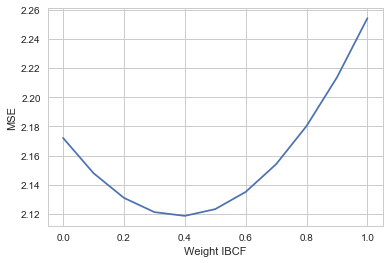

In [37]:
x = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]
y = [2.172125931973798, 2.14794686843872, 2.130967144274184, 2.121186759480191, 2.118605714056742, 2.1232240080038354, 2.1350416413214712, 2.1540586140096507, 2.1802749260683725, 2.213690577497638, 2.2543055682974464]
xy = {}

for i in range(len(x)):
    xy[x[i]] = y[i]

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.plot(x,y)
plt.xlabel('Weight IBCF')
plt.ylabel('MSE')
